<a href="https://colab.research.google.com/github/AnujShelat/ReviewDataProject/blob/master/Learning_to_Rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Import Dependencies

In [ ]:
# Import dependencies here
import numpy as np
import pandas as pd
import matplotlib
import xgboost as xgb
from xgboost import DMatrix
from sklearn.datasets import load_svmlight_file

### 2) Download Dataset

The MSLR-WEB10K dataset should exist in the working directory so that it can be referenced throughout this notebook.

In [8]:
from google.colab import files
src = list(files.upload().values())[0]
open('trans_data.py','wb').write(src)
import trans_data

Saving trans_data.py to trans_data.py


### 3) Preprocess and evaluate the dataset

In [6]:
# Preprocess and evaluate the dataset 

In [11]:
# Run the preprocess function for each dataset and add the output files to the working directory.
%%shell
python trans_data.py train.txt mslr.train train.group
python trans_data.py vali.txt mslr.vali vali.group
python trans_data.py test.txt mslr.test test.group


4) Build ranking model

In [12]:
# Build ranking model
# Load datasets into svmlight format
x_train, y_train = load_svmlight_file('mslr.train')
x_valid, y_valid = load_svmlight_file('mslr.vali')
x_test, y_test = load_svmlight_file('mslr.test')

# Open the group data in read mode for each dataset
group_train = []
with open('train.group', "r") as f:
    data = f.readlines()
    for line in data:
        group_train.append(int(line.split("\n")[0]))

group_valid = []
with open('vali.group', "r") as f:
    data = f.readlines()
    for line in data:
        group_valid.append(int(line.split("\n")[0]))

group_test = []
with open('test.group', "r") as f:
    data = f.readlines()
    for line in data:
        group_test.append(int(line.split("\n")[0]))

# Construct DMatrix, the internal data structure used by XGBoost
train_dmatrix = DMatrix(x_train, y_train)
valid_dmatrix = DMatrix(x_valid, y_valid)
test_dmatrix = DMatrix(x_test)

# Set each group size for DMatrix
train_dmatrix.set_group(group_train)
valid_dmatrix.set_group(group_valid)

# Set parameters for ranking
params = {
    'objective': 'rank:pairwise',
    'eval_metric': 'ndcg',
    'eta': 0.1,
    'gamma': 0,
    'min_child_weight': 0.1,
    'max_depth': 6
}

# Train and validate the ranking model
xgb_model = xgb.train(params, train_dmatrix, num_boost_round=4,
                      evals=[(valid_dmatrix, 'validation')])

# Apply the model to the testing data
pred = xgb_model.predict(test_dmatrix)


[0]	validation-ndcg:0.793475
[1]	validation-ndcg:0.796665
[2]	validation-ndcg:0.800581
[3]	validation-ndcg:0.80896


5) Evaluate model performance

In [13]:
# Evaluate model performance
# The model performance was evaluated above using NDCG and was set within the parameters of the model

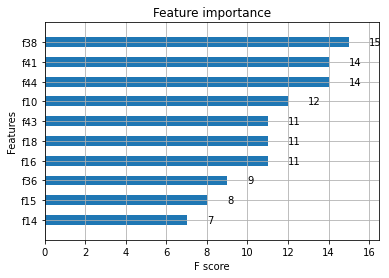

In [14]:
# Plotting the ten most significant features for the model
xgb.plot_importance(xgb_model, height=0.5, max_num_features=10)